<div class = "alert alert-info>
              <h2>Imports</h2>
              </div>

<div class = "alert alert-info">
      <h2>Imports</h2>
                  </div>

In [2]:
import os
import re
import numpy as np
from collections import Counter
import pandas as pd
import nltk
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from  keras.layers  import Embedding
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras import layers
from keras import preprocessing

Using TensorFlow backend.


<div class = "alert alert-info">
    <h2>Prétraitement</h2>
    <h3>Extraction du genre, division des oeuvres par actes, nettoyage des balises et suppression des mots vides</h3>
                  </div>

In [63]:
path = "C:/Users/Salim/Desktop/Master_AIC/TC3/Projet/projet-tc3-master/projet/corpus/theatreClassique/XML/"
liste = os.listdir(path)
stop_words = nltk.corpus.stopwords.words("french")
y = []
X = []
periode=[]

for texte in liste:
    
    try:

        f = open(path+texte,'r',encoding="utf-8")
        contenu = f.read()
        
    except UnicodeDecodeError:
        
        f = open(path+texte,'r',encoding="latin-1")
        contenu = f.read()
    
    contenu = contenu.lower()
    
    contenu = re.sub(r'\b(' + r'|'.join(stop_words) + r')\b\s*','', contenu)
        
    acts = re.findall('<div1 .*?>(.*?)</div1>',contenu,flags=re.DOTALL)
    
    y += re.findall('<genre>(.*?)</genre>',contenu)*len(acts)
    periode +=re.findall('<periode>(.*?)</periode>',contenu)*len(acts)

    for i in range(len(acts)):
        
        acts[i] = re.sub('<.*?>', ' ', acts[i])
        
        acts[i] = re.sub("(\s*\n\t*\s*)", " \n ", acts[i])
        
        X.append(acts[i])
        
    f.close()

len(X),len(y),len(periode)

(3156, 3156, 3156)

<div class = "alert alert-info">
      <h2>Choix des données relevantes et suppression des duplications</h2>
                  </div>

<div class="alert alert-warning">

<h2>  Genres</h2>
</div>

In [7]:
classes = [x[0] for x in Counter(y).most_common() if x[1] >= 10]
print("we have {} classes that exist at least 10 times, these classes are:".format(len(classes)))
classes

we have 20 classes that exist at least 10 times, these classes are:


['tragédie',
 'comédie',
 'tragi-comédie',
 'opéra',
 'drame',
 'proverbe',
 'pastorale',
 'comédie héroïque',
 'opuscule dramatique',
 'monologue',
 'tragédie musique',
 'farce',
 'comédie-ballet',
 'opéra comique',
 'parodie',
 'pastorale héroïque',
 'tragédie lyrique',
 'ballet',
 'comédie galante',
 'divertissement']

In [8]:
most_common = Counter(y).most_common(len(classes))
most_common

[('tragédie', 1190),
 ('comédie', 1096),
 ('tragi-comédie', 348),
 ('opéra', 70),
 ('drame', 65),
 ('proverbe', 43),
 ('pastorale', 28),
 ('comédie héroïque', 27),
 ('opuscule dramatique', 25),
 ('monologue', 24),
 ('tragédie musique', 23),
 ('farce', 19),
 ('comédie-ballet', 19),
 ('opéra comique', 17),
 ('parodie', 17),
 ('pastorale héroïque', 15),
 ('tragédie lyrique', 14),
 ('ballet', 11),
 ('comédie galante', 11),
 ('divertissement', 10)]

In [9]:
nbre_acts = np.sum([x[1] for x in most_common])

maxlen = np.max([len(x.split(" ")) - np.sum(np.array(x.split(" ")) == "") for x in X])
minlen = np.min([len(x.split(" ")) - np.sum(np.array(x.split(" ")) == "") for x in X])
meanlen = np.mean([len(x.split(" ")) - np.sum(np.array(x.split(" ")) == "") for x in X])

print("The overall dataset now is about {} acts".format(nbre_acts))
print("the mean number of words (including punctuations) in an act is {}".format(meanlen))
print("the max number of words (including punctuations) in an act is {}".format(maxlen))
print("the min number of words (including punctuations) in an act is {}".format(minlen))

The overall dataset now is about 3072 acts
the mean number of words (including punctuations) in an act is 2486.9515209125475
the max number of words (including punctuations) in an act is 17365
the min number of words (including punctuations) in an act is 75


In [10]:
df = pd.DataFrame({"Acts":np.array(X),"Labels":np.array(y)})

data = df[df["Labels"].apply(lambda x: x in classes)]

In [11]:
data.describe()

,Acts,Labels
count,3072,3072
unique,3066,20
top,annexes \n liste oeuvres théâtrales jean raci...,tragédie
freq,4,1190


In [18]:
data = data.drop_duplicates()

In [19]:
data.describe()

,Acts,Labels
count,3066,3066
unique,3066,20
top,"acte iv \n scène premiere. aufide, camille. \...",tragédie
freq,1,1184


In [20]:
data["Labels"] = pd.Categorical(data["Labels"])

data["LabelsNum"] = data["Labels"].cat.codes

<div class="alert alert-warning">

<h2>  Periodes</h2>
</div>

In [77]:
np.unique(periode)

array(['(antique)', '(medieval)', '1501-1600', '1601-1700', '1701-1710',
       '1701-1800', '1801-1900', '1901-2000'], dtype='<U10')

In [76]:
for i in range(len(periode)):
    if periode[i] in ['1541-1550', '1571-1580']:
        periode[i]='1501-1600'
    elif periode[i] in ['1611-1620', '1621-1630', '1631-1640', '1641-1650', '1651-1660','1661-1670', '1671-1680', '1681-1690', '1691-1700']:
        periode[i]='1601-1700'
    elif periode[i] in ['1711-1720', '1721-1730', '1731-1740', '1741-1750', '1751-1760','1761-1770', '1771-1780', '1781-1790', '1791-1800']:
        periode[i]='1701-1800'
    elif periode[i] in ['1801-1810','1821-1830', '1831-1840', '1841-1850', '1851-1860', '1861-1870','1871-1880', '1881-1890', '1891-1900']:
        periode[i]='1801-1900'
    elif periode[i] in ['1901-1910', '1911-1920']:
        periode[i]='1901-2000'

In [78]:
classesP = [x[0] for x in Counter(periode).most_common() if x[1] >= 10]
print("we have {} classes that exist at least 10 times, these classes are:".format(len(classesP)))
classesP

we have 6 classes that exist at least 10 times, these classes are:


['1601-1700', '1701-1800', '1701-1710', '1801-1900', '(antique)', '1501-1600']

In [79]:
most_commonP = Counter(periode).most_common(len(classesP))
most_commonP

[('1601-1700', 1802),
 ('1701-1800', 1036),
 ('1701-1710', 131),
 ('1801-1900', 115),
 ('(antique)', 47),
 ('1501-1600', 22)]

In [83]:
dfP = pd.DataFrame({"Acts":np.array(X),"Labels":np.array(y),"Periodes":np.array(periode)})

dataP = dfP[dfP["Periodes"].apply(lambda x: x in classesP)]

In [84]:
dataP.describe()

,Acts,Labels,Periodes
count,3153,3153,3153
unique,3147,49,6
top,annexes \n liste oeuvres théâtrales jean raci...,tragédie,1601-1700
freq,4,1190,1802


In [86]:
dataP["Periodes"] = pd.Categorical(dataP["Periodes"])

dataP["PeriodesNum"] = dataP["Periodes"].cat.codes

C:\Users\Salim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Salim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<div class = "alert alert-info">
      <h2>Préparation à l'entrainement - distribution identique par classe </h2>
                  </div>

<div class="alert alert-warning">

<h2>  Toutes les classes</h2>
</div>

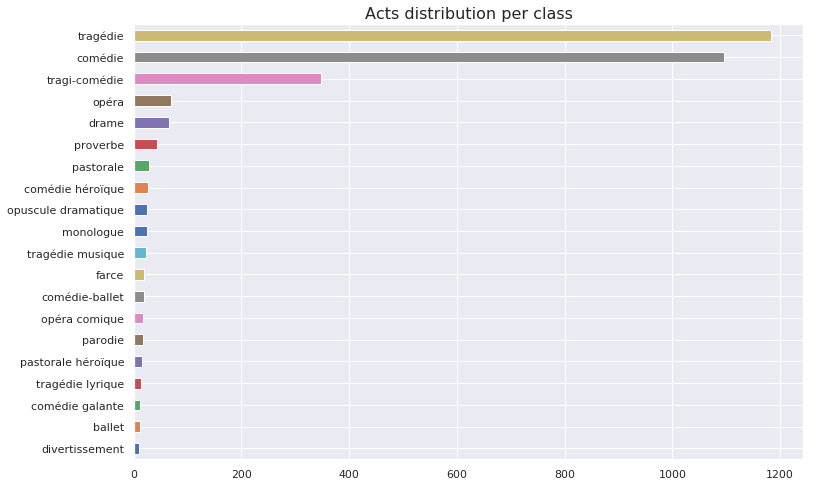

In [166]:
sns.set()

plt.figure(figsize=(12,8))

plt.title("Acts distribution per class",fontsize = 16)

pd.Series(data["Labels"].values).value_counts(ascending = True).plot(kind='barh')

plt.show()

In [22]:
sss = StratifiedShuffleSplit(test_size = 0.25)

acts = data["Acts"].values
labels = data["LabelsNum"].values

for train_index, test_index in sss.split(acts,labels):
    
    X_train, X_test = acts[train_index], acts[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [23]:
X_train.shape,X_test.shape

((2299,), (767,))

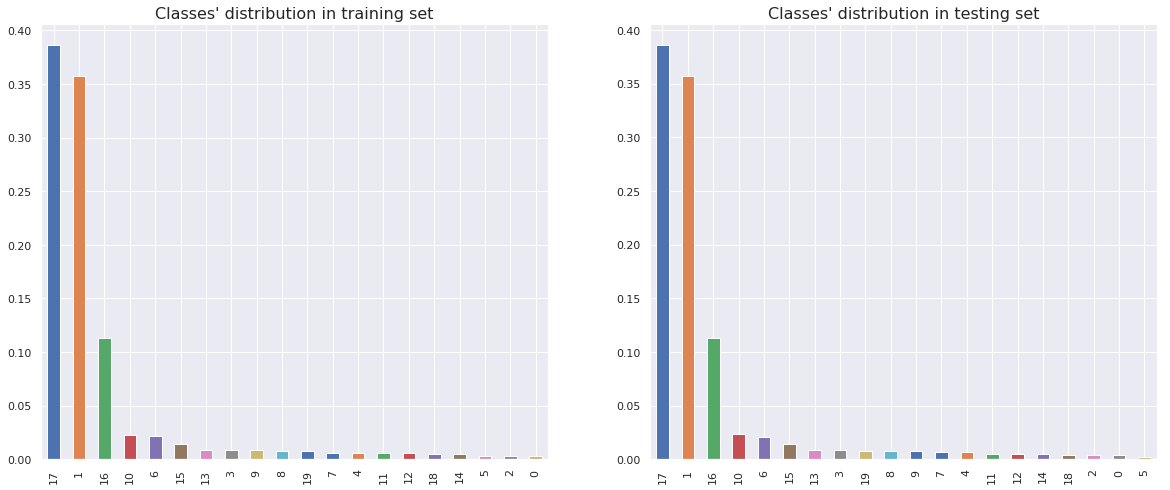

In [188]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.title("Classes' distribution in training set",fontsize = 16)
pd.Series(y_train).value_counts(normalize = True).plot(kind='bar')

plt.subplot(122)
plt.title("Classes' distribution in testing set",fontsize = 16)
pd.Series(y_test).value_counts(normalize = True).plot(kind='bar')

plt.show()

<div class="alert alert-warning">

<h2>  2 Classes: Tragédie et comédie</h2>
</div>

In [45]:
data2=data[data['Labels']=='tragédie']
data2bis=data[data['Labels']=='comédie']
Data2=pd.concat([data2,data2bis],axis=0)

In [49]:
sss2 = StratifiedShuffleSplit(test_size = 0.25)

acts2 = Data2["Acts"].values
labels2 = Data2["LabelsNum"].values

for train_index2, test_index2 in sss.split(acts2,labels2):
    
    X_train2, X_test2 = acts2[train_index2], acts2[test_index2]
    y_train2, y_test2 = labels2[train_index2], labels2[test_index2]

In [50]:
X_train2.shape,X_test2.shape

((1710,), (570,))

<div class="alert alert-warning">
<h2>  Périodes</h2>
</div>

In [89]:
sssP = StratifiedShuffleSplit(test_size = 0.25)

actsP = dataP["Acts"].values
labelsP = dataP["PeriodesNum"].values

for train_indexP, test_indexP in sss.split(actsP,labelsP):
    
    X_trainP, X_testP = actsP[train_indexP], actsP[test_indexP]
    y_trainP, y_testP = labelsP[train_indexP], labelsP[test_indexP]

In [90]:
X_trainP.shape,X_testP.shape

((2364,), (789,))

<div class="alert alert-info">
    <h2>Word Embedding</h2>
    </div>

<div class="alert alert-warning">

<h2>  Toutes les classes</h2>
</div>

In [27]:
maxlen  = 2500

tokenizer = Tokenizer(num_words = 10000)

tokenizer.fit_on_texts(X_train)

sequences = np.array(tokenizer.texts_to_sequences(X_train))

X_train = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

tokenizer = Tokenizer(num_words=10000)

tokenizer.fit_on_texts(X_test)

sequences = np.array(tokenizer.texts_to_sequences(X_test))

X_test = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

y_train = pd.get_dummies(y_train)

y_test = pd.get_dummies(y_test)

In [28]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2299, 2500), (767, 2500), (2299, 20), (767, 20))

In [58]:
model = Sequential()
model.add(Embedding(10000,64, input_length = maxlen))
model.add(Flatten())
model.add(Dense(20,activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(20, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2500, 64)          640000    
_________________________________________________________________
flatten_5 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 20)                3200020   
_________________________________________________________________
dense_14 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_15 (Dense)             (None, 20)                420       
Total params: 3,840,860
Trainable params: 3,840,860
Non-trainable params: 0
_________________________________________________________________
Train on 1839 samples, validate on 460 samples
Epoch 1/50
1839/1839 [==============================] - 5s 3ms/step - loss: 2.4720 - 

In [59]:
results = model.evaluate(X_test, y_test)
results

767/767 [==============================] - 0s 639us/step


[6.114644835794143, 0.35984354581795586]

<div class="alert alert-warning">

<h2>  2 Classes: Tragédie et comédie</h2>
</div>

In [51]:
maxlen  = 2500

tokenizer = Tokenizer(num_words = 10000)

tokenizer.fit_on_texts(X_train2)

sequences = np.array(tokenizer.texts_to_sequences(X_train2))

X_train2 = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

tokenizer = Tokenizer(num_words=10000)

tokenizer.fit_on_texts(X_test2)

sequences = np.array(tokenizer.texts_to_sequences(X_test2))

X_test2 = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

y_train2 = pd.get_dummies(y_train2)

y_test2 = pd.get_dummies(y_test2)

In [52]:
X_train2.shape,X_test2.shape,y_train2.shape,y_test2.shape

((1710, 2500), (570, 2500), (1710, 2), (570, 2))

In [62]:
model2 = Sequential()
model2.add(Embedding(10000,64, input_length = maxlen))
model2.add(Flatten())
model2.add(Dense(50,activation="relu"))
model2.add(Dense(50, activation="relu"))
model2.add(Dense(2, activation='sigmoid'))
model2.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics = ['accuracy'])
model2.summary()
history = model2.fit(X_train2, y_train2, epochs = 50, batch_size = 128, validation_split = 0.2)

ValueError: This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 

In [61]:
results2 = model2.evaluate(X_test2, y_test2)
results2

570/570 [==============================] - 1s 968us/step


[0.9209793063632229, 0.7298245626583434]

<div class="alert alert-warning">
<h2>  Périodes</h2>
</div>

In [92]:
maxlen  = 2500

tokenizer = Tokenizer(num_words = 10000)

tokenizer.fit_on_texts(X_trainP)

sequences = np.array(tokenizer.texts_to_sequences(X_trainP))

X_trainP = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

tokenizer = Tokenizer(num_words=10000)

tokenizer.fit_on_texts(X_testP)

sequences = np.array(tokenizer.texts_to_sequences(X_testP))

X_testP = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

y_trainP = pd.get_dummies(y_trainP)

y_testP = pd.get_dummies(y_testP)

In [93]:
X_trainP.shape,X_testP.shape,y_trainP.shape,y_testP.shape

((2364, 2500), (789, 2500), (2364, 6), (789, 6))

In [94]:
model = Sequential()
model.add(Embedding(10000,64, input_length = maxlen))
model.add(Flatten())
model.add(Dense(20,activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(6, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()
history = model.fit(X_trainP, y_trainP, epochs = 50, batch_size = 128, validation_split = 0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 2500, 64)          640000    
_________________________________________________________________
flatten_7 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 20)                3200020   
_________________________________________________________________
dense_23 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 126       
Total params: 3,840,566
Trainable params: 3,840,566
Non-trainable params: 0
_________________________________________________________________
Train on 1891 samples, validate on 473 samples
Epoch 1/50
1891/1891 [==============================] - 7s 3ms/step - loss: 1.1608 - 

In [95]:
resultsP = model.evaluate(X_testP, y_testP)
resultsP

789/789 [==============================] - 1s 650us/step


[2.687499891820214, 0.567807351757214]

<div class="alert alert-info">
<h2>Use pretrained word embedding</h2>
</div>

In [35]:
imdb_dir = os.getcwd()+'/aclImdb'

train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    
    dir_name = os.path.join(train_dir, label_type)
    
    for fname in os.listdir(dir_name):
        
        if fname[-4:] == '.txt':
            
            f = open(os.path.join(dir_name, fname))
            
            texts.append(f.read())
            
            f.close()
        if label_type == 'neg':

            labels.append(0)

        else:

            labels.append(1)

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'C:\\Users\\Salim/aclImdb\\train\\neg'

In [231]:
maxlen = 100

training_samples = 200

validation_samples = 10000

max_words = 10000

tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

In [232]:
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])

np.random.shuffle(indices)

data = data[indices]

labels = labels[indices]

x_train = data[:training_samples]

y_train = labels[:training_samples]

x_val   = data[training_samples: training_samples + validation_samples]

y_val   = labels[training_samples: training_samples + validation_samples]




Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)
